In [7]:
import numpy as np
import matplotlib.pyplot as plt 
import numba
from numba import jit
from PIL import Image,ImageOps

The heat equation $$\alpha \nabla^2 u = \frac{\partial u}{ \partial t}$$

* $u$ is temperature
* $\alpha$ is the thermal diffusivity
* $t$ is time

In two dimensions and in discrete form, can be written as:

$$\alpha \left( \frac{u_{i+1,j}^{(m)} -2u_{i,j}^{(m)} + u_{i-1,j}^{(m)}}{\Delta x^2} + \frac{u_{i,j+1}^{(m)} -2u_{i,j}^{(m)} + u_{i,j-1}^{(m)}}{\Delta y^2}\right) = \frac{u_j^{(m+1)} - u_j^{(m)}}{\Delta t} $$ 
Taking $\Delta x = \Delta y $ and rearranging to solve for $m+1$ 

$$ u_j^{(m+1)} = u_j^{(m)} + \alpha \frac{\Delta t}{\Delta x^2} \left( u_{i+1,j}^{(m)} + u_{i-1,j}^{(m)} +  u_{i,j+1}^{(m)} + u_{i,j-1}^{(m)}  -4u_{i,j}^{(m)} \right) $$

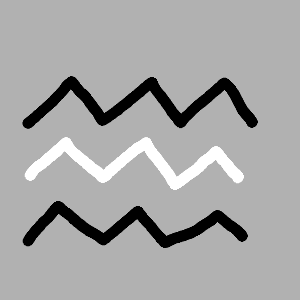

In [8]:
img = Image.open('images/accordion.png')
img = ImageOps.grayscale(img)
img

In [9]:
# load the image 
img = np.asarray(img,dtype='int32')
img = img/255                           # normalize it 

HV_bool = img<0.05                      # HV for the upper and lower 
LV_bool = img>0.95                      # LV for the middle plate 

fixed_bool = HV_bool + LV_bool

In [10]:
a_al = 1.32e-7                          # thermal coeffcient for AL 
HV_temp = 273.15 + 150                  # HV temp 
LV_temp = 273.15 + 100                  # LV temp 
room_temp = 273.15 + 27                 # room temperature 

N,M = img.shape
init_heat = np.zeros((N,M)) + room_temp # assign room temp to everywhere
init_heat[HV_bool] = HV_temp            # set the HV to HV temp 
init_heat[LV_bool] = LV_temp            # set LV to LV temp 


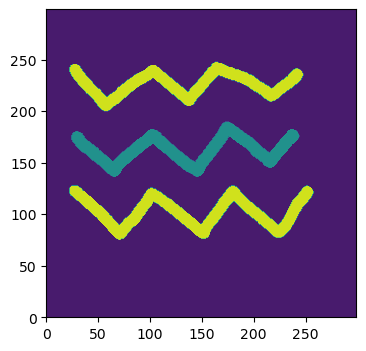

In [11]:
# plot the inital temp distribution 
plt.figure(figsize=(4,4))
plt.contourf(init_heat)

In [12]:
times = 36000                                           # no of time steps (or iterations in time)
times_snapshot = 3600                                   # record temp at each 10s intervals
f = int(times/times_snapshot)
heat_frames = np.zeros([times_snapshot, 300, 300])      # matrix to record temp 
heat_frames[0] = init_heat                              # assing the zero frame to initial temp 

In [13]:
x = 0.5                                                 # length(which is equal to height in this case)
dx = 0.5/N                                              # dx (step size in space dim)
dt = 1                                                  # dt (step size in time)

print(f'{a_al*dt/dx**2} << 1/4')                        # To converge the finite difference eq. above 

0.047519999999999986 << 1/4


In [14]:
# iteratively solve for temperature (over time)
@numba.jit("f8[:,:,:](f8[:,:,:], b1[:,:])", nopython=True, nogil=True)
def solve_heat(heatmap, is_bool):
    cs = heatmap[0].copy() #current state
    length = len(cs[0])
    cf = 0 # current frame
    for t in range(1,times):
        ns = cs.copy() # new state
        for i in range(1, length-1):
            for j in range(1, length-1):
                if is_bool[j][i]:
                    a = a_al
                    ns[j][i] = cs[j][i] + a*dt/dx**2 * (cs[j+1][i] + cs[j-1][i] +\
                                                    cs[j][i+1] + cs[j][i-1] -\
                                                    4*cs[j][i])
        cs = ns.copy()
        if t%f==0:
            cf = cf + 1
            heatmap[cf] = cs
            
    return heatmap

In [15]:
# get heat frames 
heat_frames = solve_heat(heat_frames,fixed_bool)

In [16]:
# get back to celcius scale 
heat_frames-=273.15

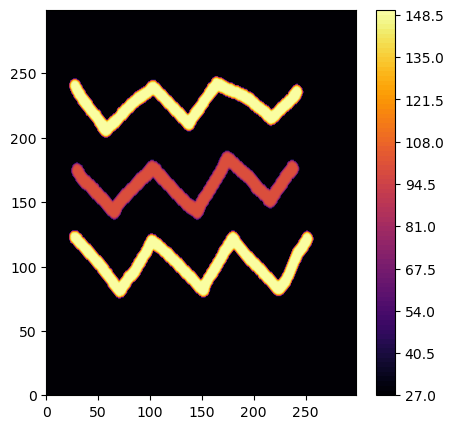

In [20]:
# plot the heat map after 10s 
my_cmap = plt.get_cmap('inferno')
plt.figure(figsize=(5,5))
a = plt.contourf(heat_frames[1], 100, cmap=my_cmap)# vmin=room_temp-273.15, vmax=HV_temp-273.15)
plt.colorbar(a)

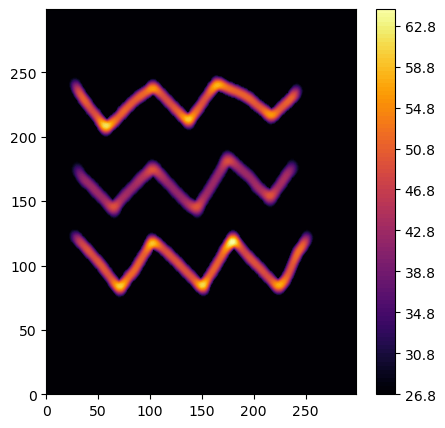

In [21]:
# plot heatmap after 500 s
my_cmap = plt.get_cmap('inferno')
plt.figure(figsize=(5,5))
a = plt.contourf(heat_frames[50], 100, cmap=my_cmap)# vmin=room_temp-273.15, vmax=HV_temp-273.15)
plt.colorbar(a)